# **Modelling and Evaluation Notebook**

## Objectives

* tune features for machine learning model
* carry out data classification for healthy and infected cherry leaves

## Inputs

* inputs/cherry_leaves_data/test
* inputs/cherry_leaves_data/train
* inputs/cherry_leaves_data/validation
* image shape pickle file

## Outputs

* Plot of image distribution from train, validation, and test sets
* Image augmentation
* Class indices to change prediction inference in labels
* Create and train and save ML model 
* Plot learning curve to show model performance
* evaluation of model on pickle file
* Prediction on a random image file


---

# Change working directory

import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

We will change the working directory from its current folder to its parent folder using the method os.cetcwd.


In [2]:
working_dir = os.getcwd()
working_dir

'/workspace/showMeMildew/jupiter_notebooks'

here we make the parent of our current directory to the current directory
*  we pass os.path.dirname() as an arguement which gets the parent directory




In [3]:
os.chdir(os.path.dirname(working_dir))
print("You set a new current directory")

You set a new current directory


to confirm we have changed our directory

In [4]:
working_dir = os.getcwd()
working_dir

'/workspace/showMeMildew'

## Set Data directories

### Set Input Directory

Define data path of the train, test and validation datasets.

In [5]:
root_dir = 'inputs/cherry_leaves_data/cherry-leaves/'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
validation_dir = os.path.join(root_dir, 'validation')


### Set ouput directory

In [6]:
version = 'v1.0'

file_path = f'outputs/{version}'
version_file_path = os.path.join(working_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1.0 already exists. Create a new version


### Set label names

In [7]:
labels = os.listdir(train_dir)
print('images labels are: ', labels)

images labels are:  ['healthy', 'powdery_mildew']


### Image shape

Import image shape file from 02-DataVisualization notebook

In [8]:
import joblib

version = 'v1.0'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pk1")
image_shape

(100, 100, 3)

---

### assess the number of images in each dataset

* dataset: train - folder: healthy: contains 1472 images
* dataset: train - folder: powdery_mildew: contains 1472 images
* dataset: validation - folder: healthy: contains 210 images
* dataset: validation - folder: powdery_mildew: contains 210 images
* dataset: test - folder: healthy: contains 422 images
* dataset: test - folder: powdery_mildew: contains 422 images




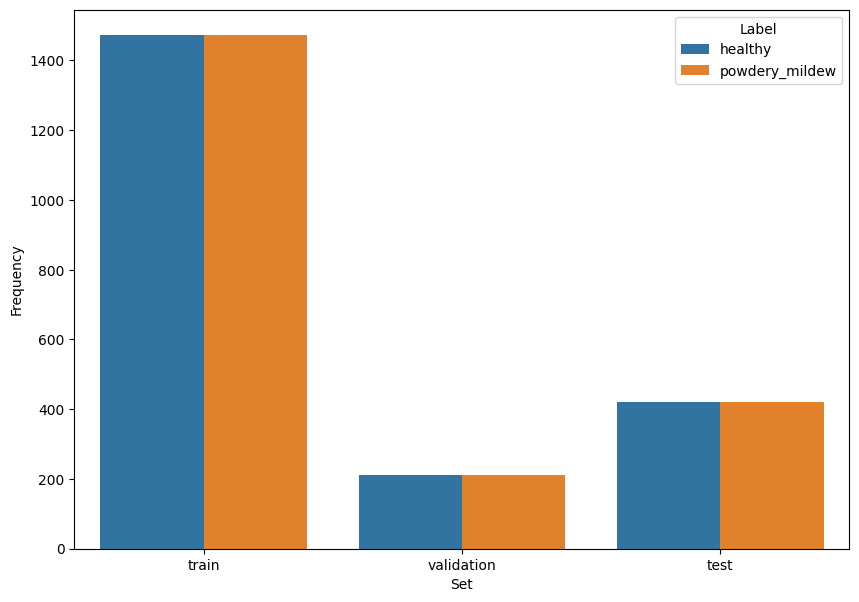

In [9]:
data_frame_frequency = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    label_data = os.listdir(root_dir+'/'+ folder + '/' + label)
    data_frame_frequency = data_frame_frequency.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(label_data))
                        }), ignore_index=True)
    
    print(f"* dataset: {folder} - folder: {label}: contains {len(label_data)} images")

print("\n")

plt.figure(figsize=(10,7))
sns.barplot(data=data_frame_frequency, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

the analysis of the content of the dataset shows that train set contains 1472 images for both classifications which isnt a big enough pool of images for a deep learning model. we will now inflate this pool by carrying out data augmentation.

### Define parameters for the loader

In [10]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

### Import ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-04-03 17:38:15.377094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 17:38:15.377130: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Initialize ImageDataGenerator

In [12]:
image_augmentation = ImageDataGenerator(
                                   width_shift_range=0.15, 
                                   height_shift_range=0.15,
                                   zoom_range=0.15,
                                   shear_range=0.15,
                                   rotation_range=18,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Augement train dataset

In [13]:
train_set = image_augmentation.flow_from_directory(train_dir,
                                              target_size=image_shape[:2],
                                              color_mode=data_color_mode,
                                              batch_size=batch_size,
                                              class_mode=data_class_mode,
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir,
                                                          target_size=image_shape[:2],
                                                          color_mode=data_color_mode,
                                                          batch_size=batch_size,
                                                          class_mode=data_class_mode,
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                    target_size=image_shape[:2],
                                                    color_mode=data_color_mode,
                                                    batch_size=batch_size,
                                                    class_mode=data_class_mode,
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented image from training dataset

In [16]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()

plot train set

(32, 100, 100, 3)


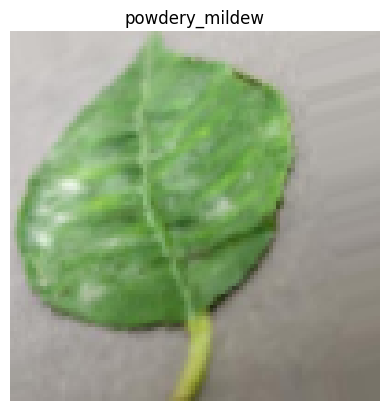

(32, 100, 100, 3)


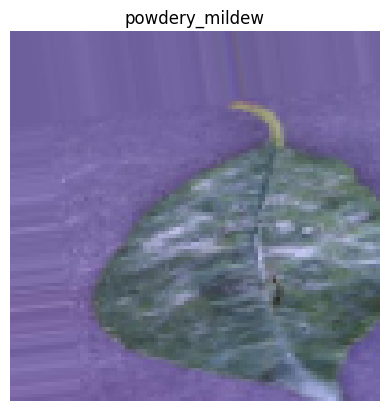

(32, 100, 100, 3)


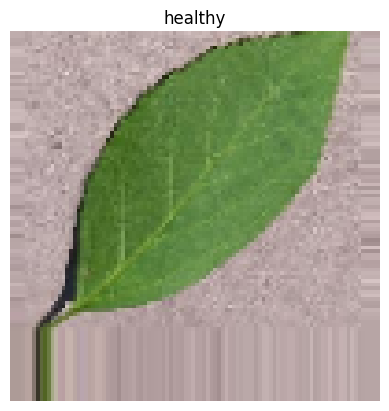

In [17]:
plot_augmented_image(train_set)

plot validation set

(32, 100, 100, 3)


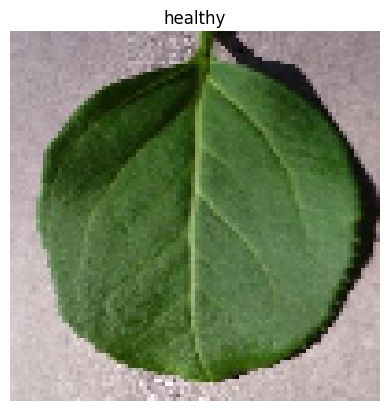

(32, 100, 100, 3)


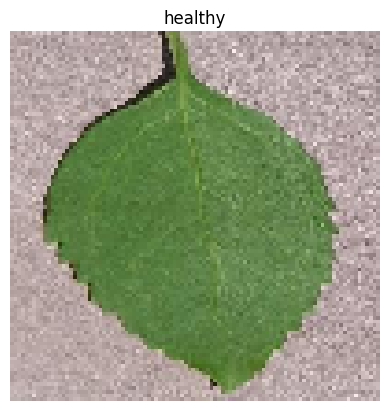

(32, 100, 100, 3)


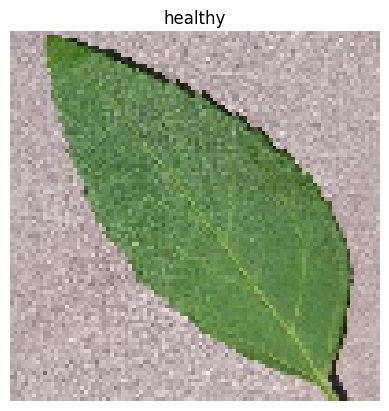

In [18]:
plot_augmented_image(validation_set)

Plot test set images

(32, 100, 100, 3)


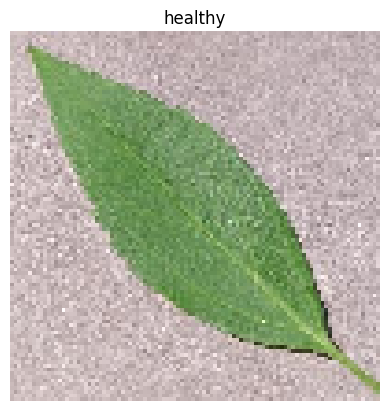

(32, 100, 100, 3)


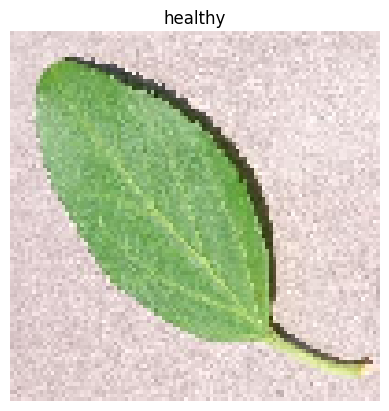

(32, 100, 100, 3)


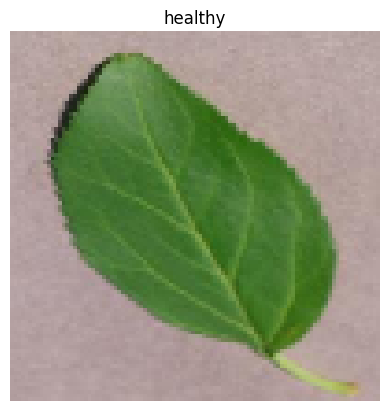

In [19]:
plot_augmented_image(test_set)

save class_indices

In [20]:
joblib.dump(value=train_set.class_indices, 
            filename = f'{file_path}/class_indices.pkl')

['outputs/v1.0/class_indices.pkl']

## Model Creation

The chosen model for the research is the Convolutional Neural Network (CNN), which is designed to detect and learn from the most prominent features of the pre-labeled "powdery mildew" leaf.

### ML Model

import model packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

define parameters

In [22]:
EPOCHS = 15
OUTPUT_DIR = 'outputs/v1.0'

Create model

In [23]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=4, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model


Model summary

In [24]:
create_model().summary()

2023-04-03 17:38:21.657448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-03 17:38:21.657492: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 17:38:21.657517: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (davidjpward-showmemilde-8l1ogtbe5oc): /proc/driver/nvidia/version does not exist
2023-04-03 17:38:21.657806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 4)         292       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 4)        0

Model Network Architecture

Abort model

In [25]:
Abort = EarlyStopping(monitor='val_loss', patience=3)

In [26]:
 len(train_set.classes)

2944

---

Fit model for training

In [27]:
model = create_model()
model.fit(train_set,
          epochs=EPOCHS,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data = validation_set,
          callbacks=[Abort],
          verbose=1)

Epoch 1/15
92/92 [==============================] - 10s 100ms/step - loss: 0.4628 - accuracy: 0.7636 - val_loss: 0.1491 - val_accuracy: 0.9452
Epoch 2/15
92/92 [==============================] - 12s 130ms/step - loss: 0.1624 - accuracy: 0.9524 - val_loss: 0.0658 - val_accuracy: 0.9738
Epoch 3/15
92/92 [==============================] - 12s 133ms/step - loss: 0.0931 - accuracy: 0.9749 - val_loss: 0.0969 - val_accuracy: 0.9714
Epoch 4/15
92/92 [==============================] - 9s 98ms/step - loss: 0.0743 - accuracy: 0.9803 - val_loss: 0.0652 - val_accuracy: 0.9762
Epoch 5/15
92/92 [==============================] - 14s 150ms/step - loss: 0.0709 - accuracy: 0.9806 - val_loss: 0.0231 - val_accuracy: 0.9929
Epoch 6/15
92/92 [==============================] - 14s 157ms/step - loss: 0.0583 - accuracy: 0.9837 - val_loss: 0.0383 - val_accuracy: 0.9881
Epoch 7/15
92/92 [==============================] - 10s 105ms/step - loss: 0.0382 - accuracy: 0.9901 - val_loss: 0.0315 - val_accuracy: 0.9881
E

Save our model

In [28]:
model.save(f'{OUTPUT_DIR}/show_me_mildew_model.h5')

## Model Performance

Model Learning Curve

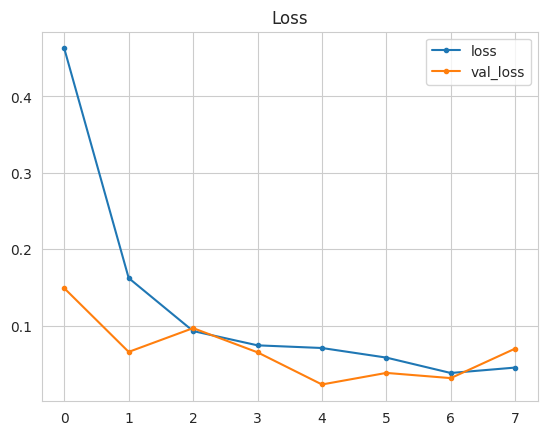

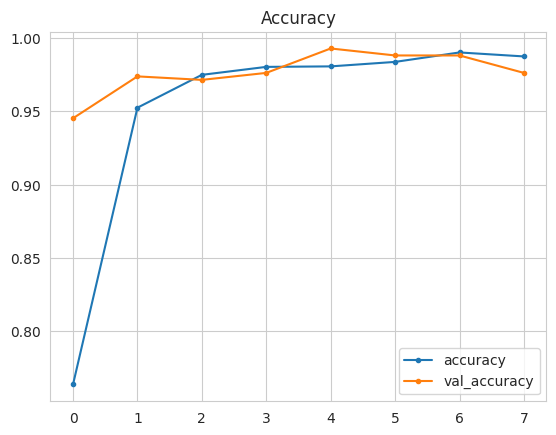

In [29]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

Model Evaluation

In [30]:
from keras.models import load_model
model = load_model(f'{OUTPUT_DIR}/show_me_mildew_model.h5')

Evaluate model using test set

In [31]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 1s 49ms/step - loss: 0.0744 - accuracy: 0.9834


Save the evaluation pickle

In [32]:
joblib.dump(value=evaluation, filename=f'{OUTPUT_DIR}/evaluation.pk1')

['outputs/v1.0/evaluation.pk1']

Predict on new data

Image shape: (100, 100), Image mode: RGB


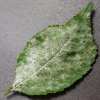

In [33]:
from tensorflow.keras.preprocessing import image

pointer = 80
label = labels[1] # select from the powdery mildew leaf
img = os.listdir(f'{test_dir}/{label}')[pointer]
file_to_load = os.path.join(test_dir, label, img)

pil_image = image.load_img(file_to_load, target_size = image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array for prediction

In [34]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


Predict class probabilities

In [35]:
prediction_probability = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
predicted_class =  target_map[prediction_probability > 0.5]  

if predicted_class == target_map[0]: prediction_probability = 1 - prediction_probability

print(f'Prediction probability: {prediction_probability}')
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 0s 90ms/step
Prediction probability: 0.9955357313156128
Predicted class: powdery_mildew


---

## Push Files to repo

.gitignore

In [36]:
!cat .gitignore


core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
envs/

Commit and push

!git add .
!git commit
!git push